# Importing the Necessary Libraries

In [7]:
# Install dependencies (this is mostly for Google Colab, as the other dependences are available by default in Colab)
try:
  import datasets, evaluate, accelerate
  import gradio as gr
except ModuleNotFoundError:
  !pip install -U datasets evaluate accelerate gradio # -U stands for "upgrade" so we'll get the latest version by default
  import datasets, evaluate, accelerate
  import gradio as gr

import random

import numpy as np
import pandas as pd

import torch
import transformers

print(f"Using transformers version: {transformers.__version__}")
print(f"Using datasets version: {datasets.__version__}")
print(f"Using torch version: {torch.__version__}")

Using transformers version: 4.48.3
Using datasets version: 3.3.0
Using torch version: 2.5.1+cu124


# Getting a Dataset

## Loading the Dataset

In [8]:
# Load the dataset from Hugging Face Hub
dataset = datasets.load_dataset(path="mrdbourke/learn_hf_food_not_food_image_captions")

# Inspect the dataset
dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/11.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/250 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 250
    })
})

In [9]:
# What features are there?
dataset.column_names

{'train': ['text', 'label']}

In [10]:
dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 250
})

In [11]:
import random

random_indexs = random.sample(range(len(dataset["train"])), 5)
random_samples = dataset["train"][random_indexs]

print(f"[INFO] Random samples from dataset:\n")
for item in zip(random_samples["text"], random_samples["label"]):
    print(f"Text: {item[0]} | Label: {item[1]}")

[INFO] Random samples from dataset:

Text: Mouthwatering mushroom curry, featuring shiitake and button mushrooms in a rich coconut milk sauce with spices and herbs. | Label: food
Text: Gluten-free sushi roll using tamari sauce instead of soy sauce. | Label: food
Text: Friends having a barbecue in the backyard while pets play nearbyA collection of cleaning products under the sink | Label: not_food
Text: Pizza with a seasonal theme, featuring toppings like butternut squash and kale | Label: food
Text: Rich and spicy lamb rogan josh with yogurt garnish, featuring tender lamb pieces in a bold sauce with spices, finished with creamy yogurt. | Label: food


In [12]:
# Get unique label values
dataset["train"].unique("label")

['food', 'not_food']

In [13]:
# Check number of each label
from collections import Counter

Counter(dataset["train"]["label"])

Counter({'food': 125, 'not_food': 125})

# Preparing data for text classification
 The two main steps :
   1.Tokenisation
   2.Creating a train/test split

## Create a mapping from labels to numbers

In [14]:
# Create mappings programmatically from dataset
id2label = {idx: label for idx, label in enumerate(dataset["train"].unique("label")[::-1])} # reverse sort list to have "not_food" first
label2id = {label: idx for idx, label in id2label.items()}

print(f"Label to ID mapping: {label2id}")
print(f"ID to Label mapping: {id2label}")

Label to ID mapping: {'not_food': 0, 'food': 1}
ID to Label mapping: {0: 'not_food', 1: 'food'}


In [15]:
# Turn labels into 0 or 1 (e.g. 0 for "not_food", 1 for "food")
def map_labels_to_number(example):
  example["label"] = label2id[example["label"]]
  return example

example_sample = {"text": "This is a sentence about my favourite food: honey.", "label": "food"}

# Test the function
map_labels_to_number(example_sample)

{'text': 'This is a sentence about my favourite food: honey.', 'label': 1}

In [16]:
# Map our dataset labels to numbers
dataset=dataset['train'].map(map_labels_to_number)
dataset[:5]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

{'text': ['Creamy cauliflower curry with garlic naan, featuring tender cauliflower in a rich sauce with cream and spices, served with garlic naan bread.',
  'Set of books stacked on a desk',
  'Watching TV together, a family has their dog stretched out on the floor',
  'Wooden dresser with a mirror reflecting the room',
  'Lawn mower stored in a shed'],
 'label': [1, 0, 0, 0, 0]}

In [17]:
# Shuffle the dataset
dataset.shuffle()

Dataset({
    features: ['text', 'label'],
    num_rows: 250
})

## Split the dataset into training and test sets

In [18]:
dataset=dataset.train_test_split(test_size=0.2,seed=42)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 50
    })
})

## Tokenizing text data

In [19]:
from transformers import AutoTokenizer
tokenizer=AutoTokenizer.from_pretrained(pretrained_model_name_or_path="distilbert/distilbert-base-uncased",
                                        use_fast=True)
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [20]:
# Test our tokenizer
tokenizer("I love y0u")

{'input_ids': [101, 1045, 2293, 1061, 2692, 2226, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [21]:
# Get the length of the vocabulary
length_of_tokenizer_vocab=len(tokenizer.vocab)
print(f"Length of tokenizer vocabulary: {length_of_tokenizer_vocab}")

max_tokenizer_sequence_length=tokenizer.model_max_length
print(f"Max tokenizer input sequence length: {max_tokenizer_sequence_length}")

Length of tokenizer vocabulary: 30522
Max tokenizer input sequence length: 512


In [22]:
def tokenize_text(examples):
  """
  Tokenize given example text and return the tokenized text.
  """
  return tokenizer(examples["text"],
                   padding=True,
                   truncation=True)

In [23]:
# map our tokenize function to the dataset
tokenized_dataset=dataset.map(function=tokenize_text,
                              batched=True,
                              batch_size=1000)
tokenized_dataset

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50
    })
})

In [24]:
# Lets visulize the tokenized dataset text
random=random.randint
train_data_sample=tokenized_dataset['train'][0]
for key in train_data_sample.keys():
  print(f" {key} : {train_data_sample[key]}")

 text : Set of headphones placed on a desk
 label : 0
 input_ids : [101, 2275, 1997, 2132, 19093, 2872, 2006, 1037, 4624, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 attention_mask : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Evaluation metrics function

In [25]:
import evaluate
from typing import Tuple
import numpy as np

evaluate_metrics=evaluate.load("accuracy")
def evaluate_matrics(predictions_labels: Tuple[np.array,np.array]):
   predictions,labels=predictions_labels
   if(len(predictions.shape)>=2):
    predictions=np.argmax(predictions,axis=1)

   return evaluate_metrics.compute(predictions=predictions, references=labels)

In [26]:
from transformers import AutoModelForSequenceClassification

# Setup model for fine-tuning with classification head(top layers of network)

model=AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="distilbert/distilbert-base-uncased",
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
# Inspect the model
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


## Counting the parameters of our model

In [28]:
def count_params(model):
  trainable_parameters=sum(p.numel() for p in model.parameters() if p.requires_grad)
  total_parameters=sum(p.numel() for p in model.parameters())

  return {"trainable_parameters":trainable_parameters,"total_parameters":total_parameters}

count_params(model)

{'trainable_parameters': 66955010, 'total_parameters': 66955010}

## Creating a directory for saving models



In [29]:
from pathlib import Path

# create a directory
models_dir=Path("models")
models_dir.mkdir(exist_ok=True)

# create a model save name
model_save_name="hf_food_not_food_text_classification-distilbert-base-uncased"

# create model save path
model_save_dir=Path(models_dir,model_save_name)

model_save_dir

PosixPath('models/hf_food_not_food_text_classification-distilbert-base-uncased')

## Setting up the training arguements

In [30]:
from transformers import TrainingArguments

training_args=TrainingArguments(
    output_dir=model_save_dir, # saving model check points to model_save_dir
    eval_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=0.0001,
    num_train_epochs=10,
    save_strategy="epoch",
    save_total_limit=3,
    use_cpu=False,
    seed=42,
    load_best_model_at_end=True,
    logging_strategy="epoch",
    report_to="none"
)

## Setting up an trainer

In [31]:
from transformers import Trainer

#Setup Trainer
trainer=Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=evaluate_matrics
)

<ipython-input-31-96f1e25f614d>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer=Trainer(


## Train our text classification model

In [32]:
results=trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.450700,0.093145,1.000000
2,0.037000,0.007201,1.000000
3,0.004700,0.002239,1.000000
4,0.001900,0.001212,1.000000
5,0.001200,0.000856,1.000000
6,0.000900,0.000693,1.000000
7,0.000800,0.000606,1.000000
8,0.000700,0.000559,1.000000
9,0.000700,0.000534,1.000000
10,0.000700,0.000525,1.000000


In [33]:
# Inspect trainig metrics
for key,value in results.metrics.items():
  print(f"{key}:{value}")

train_runtime:387.6307
train_samples_per_second:5.16
train_steps_per_second:0.181
total_flos:18110777160000.0
train_loss:0.049942869726302366
epoch:10.0


In [34]:
# Save the model
trainer.save_model(output_dir=model_save_dir)

In [35]:
# Get training history
trainer_history_all=trainer.state.log_history
trainer_history_metrics=trainer_history_all[:-1]
training_history_training_time=trainer_history_all[-1]

trainer_history_metrics[:4]

[{'loss': 0.4507,
  'grad_norm': 1.4503164291381836,
  'learning_rate': 9e-05,
  'epoch': 1.0,
  'step': 7},
 {'eval_loss': 0.09314483404159546,
  'eval_accuracy': 1.0,
  'eval_runtime': 2.546,
  'eval_samples_per_second': 19.639,
  'eval_steps_per_second': 0.786,
  'epoch': 1.0,
  'step': 7},
 {'loss': 0.037,
  'grad_norm': 0.16689997911453247,
  'learning_rate': 8e-05,
  'epoch': 2.0,
  'step': 14},
 {'eval_loss': 0.007201096974313259,
  'eval_accuracy': 1.0,
  'eval_runtime': 2.4306,
  'eval_samples_per_second': 20.571,
  'eval_steps_per_second': 0.823,
  'epoch': 2.0,
  'step': 14}]

In [36]:
import pprint

trainer_history_training_set=[]
trainer_history_eval_set=[]

for item in trainer_history_metrics:
  item_keys=list(item.keys())
  if any("eval" in item for item in item_keys):
    trainer_history_eval_set.append(item)
  else:
    trainer_history_training_set.append(item)

# Show the first two items in each metric set
pprint.pprint(trainer_history_training_set[:2])
pprint.pprint(trainer_history_eval_set[:2])

[{'epoch': 1.0,
  'grad_norm': 1.4503164291381836,
  'learning_rate': 9e-05,
  'loss': 0.4507,
  'step': 7},
 {'epoch': 2.0,
  'grad_norm': 0.16689997911453247,
  'learning_rate': 8e-05,
  'loss': 0.037,
  'step': 14}]
[{'epoch': 1.0,
  'eval_accuracy': 1.0,
  'eval_loss': 0.09314483404159546,
  'eval_runtime': 2.546,
  'eval_samples_per_second': 19.639,
  'eval_steps_per_second': 0.786,
  'step': 7},
 {'epoch': 2.0,
  'eval_accuracy': 1.0,
  'eval_loss': 0.007201096974313259,
  'eval_runtime': 2.4306,
  'eval_samples_per_second': 20.571,
  'eval_steps_per_second': 0.823,
  'step': 14}]


In [37]:
# create pandas dataframe for the training and evaluation metrics
trainer_history_training_df=pd.DataFrame(trainer_history_training_set)
trainer_history_eval_df=pd.DataFrame(trainer_history_eval_set)

trainer_history_training_df.head()

,loss,grad_norm,learning_rate,epoch,step
0,0.4507,1.450316,0.00009,1.0,7
1,0.0370,0.166900,0.00008,2.0,14
2,0.0047,0.038489,0.00007,3.0,21
3,0.0019,0.021701,0.00006,4.0,28
4,0.0012,0.017359,0.00005,5.0,35


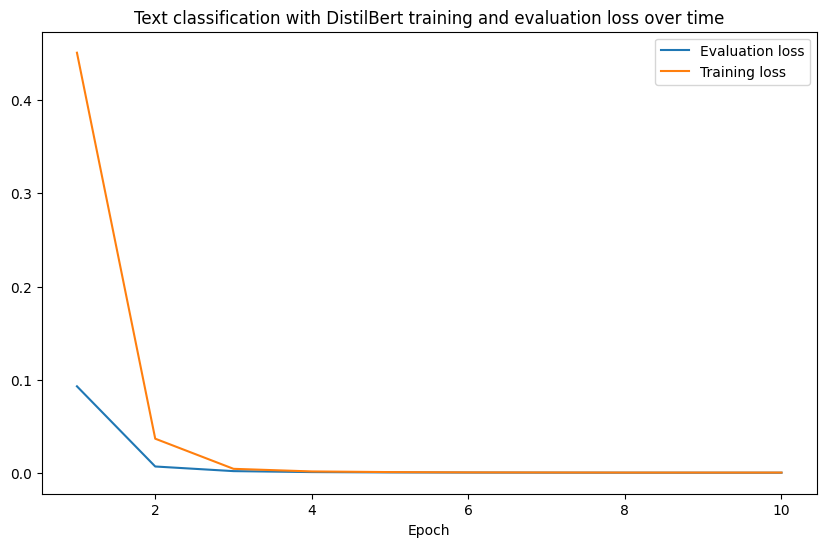

In [38]:
# Plot training and evaluate loss

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(trainer_history_eval_df["epoch"],trainer_history_eval_df["eval_loss"],label="Evaluation loss")
plt.plot(trainer_history_training_df["epoch"],trainer_history_training_df["loss"],label="Training loss")
plt.xlabel("Epoch")
plt.title("Text classification with DistilBert training and evaluation loss over time")
plt.legend()
plt.show()

## Pushing our model to the Hugging face hub

In [39]:
# Save our model to Hugging face hub
model_upload_url=trainer.push_to_hub(
    commit_message="Uploading food not food text classifier model"

)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

In [40]:
model_upload_url

CommitInfo(commit_url='https://huggingface.co/gokulan006/hf_food_not_food_text_classification-distilbert-base-uncased/commit/c65cfe1d0641504c56cc8420741d56ad9f29e13f', commit_message='Uploading food not food text classifier model', commit_description='', oid='c65cfe1d0641504c56cc8420741d56ad9f29e13f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/gokulan006/hf_food_not_food_text_classification-distilbert-base-uncased', endpoint='https://huggingface.co', repo_type='model', repo_id='gokulan006/hf_food_not_food_text_classification-distilbert-base-uncased'), pr_revision=None, pr_num=None)

## Making and Evaluating predictions on the test data

In [41]:
predictions_all=trainer.predict(tokenized_dataset['test'])
prediction_values=predictions_all.predictions
prediction_metrics=predictions_all.metrics
prediction_metrics

{'test_loss': 0.0005254194256849587,
 'test_accuracy': 1.0,
 'test_runtime': 2.2042,
 'test_samples_per_second': 22.684,
 'test_steps_per_second': 0.907}

In [42]:
import torch
from sklearn.metrics import accuracy_score

# 1.Calculate the prediction probability
pred_probs=torch.softmax(torch.tensor(prediction_values),dim=1)

# 2. Get the predicted labels
pred_labels=torch.argmax(pred_probs,dim=1)

# 3.Get the true labels
true_labels=dataset['test']['label']

# 4. Copare prediced labels to true labels
test_accuracy=accuracy_score(y_true=true_labels,
                             y_pred=pred_labels)

print(f"accuracy :{test_accuracy*100}")

accuracy :100.0


In [43]:
# Make a DataFrame of test predictions
test_predictions_df=pd.DataFrame({
    "text":dataset["test"]["text"],
    "true_labels":true_labels,
    "pred_label":pred_labels,
    "pred_prob":torch.max(pred_probs,dim=1).values
})

test_predictions_df.head()

,text,true_labels,pred_label,pred_prob
0,A slice of pepperoni pizza with a layer of mel...,1,1,0.999453
1,Red brick fireplace with a mantel serving as a...,0,0,0.999505
2,A bowl of sliced bell peppers with a sprinkle ...,1,1,0.999455
3,Set of mugs hanging on a hook,0,0,0.999527
4,Standing floor lamp providing light next to an...,0,0,0.999529


In [44]:
# Show 10 examples with low prediction probabiity
test_predictions_df.sort_values("pred_prob",ascending=True).head(10)

,text,true_labels,pred_label,pred_prob
40,A bowl of cherries with a sprig of mint for ga...,1,1,0.999437
11,A close-up shot of a cheesy pizza slice being ...,1,1,0.999444
45,"Green beans in a bowl, sprinkled with almonds ...",1,1,0.999445
42,"Boxes of apples, pears, pineapple, manadrins a...",1,1,0.999447
30,"Robust beef curry in a hearty bowl, simmered w...",1,1,0.999448
24,"Creamy mild korma curry, featuring tender chic...",1,1,0.999449
26,A fruit platter with a variety of exotic fruit...,1,1,0.999449
21,"Artichokes in a bowl, sprinkled with garlic an...",1,1,0.999449
14,Two handfuls of bananas in a fruit bowl with g...,1,1,0.999450
46,A bowl of sliced kiwi with a sprinkle of sugar...,1,1,0.999451


## Making and inspecting predictions on custom text data


In [45]:
# setup local model path
huggingface_model_path="gokulan006/hf_food_not_food_text_classification-distilbert-base-uncased"


In [46]:
def set_device():
  """
  Set device to CUDA if available,else MPS(Mac),else CPU.

  This defaults to using the best available device(usually).

  """

  if torch.cuda.is_available():
    device=torch.device("cuda")
  elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device=torch.device("mps")
  else:
    device=torch.device("cpu")
  return device


DEVICE=set_device()
print(DEVICE)

cpu


## Making predictions with pipeline


In [47]:
import torch
from transformers import pipeline

BATCH_SIZE=32

food_not_food_classifier=pipeline(task="text-classification",
                                  model=huggingface_model_path,
                                  device=DEVICE,
                                  top_k=1,
                                  batch_size=BATCH_SIZE)

food_not_food_classifier

config.json:   0%|          | 0.00/738 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cpu


In [48]:
# Test our trained model on some example text
sample_text_food="A plate of biriyani and chicke 65 "
food_not_food_classifier(sample_text_food)

[[{'label': 'food', 'score': 0.9994196891784668}]]

In [49]:
sample_text_not_food="I have a towel not to eat"
food_not_food_classifier(sample_text_not_food)

[[{'label': 'not_food', 'score': 0.9994213581085205}]]

In [50]:
from typing import Dict

# 1. Create a function which takes text as input
def food_not_food_classifier(text: str) -> Dict[str, float]:
    """
    Takes an input string of text and classifies it into food/not_food in the form of a dictionary.
    """

    # 2. Setup the pipeline to use the local model (or Hugging Face model path)
    food_not_food_classifier = pipeline(task="text-classification",
                                        model=huggingface_model_path,
                                        batch_size=32,
                                        device="cuda" if torch.cuda.is_available() else "cpu", # set the device to work in any environment
                                        top_k=None) # return all possible scores (not just top-1)

    # 3. Get outputs from pipeline (as a list of dicts)
    outputs = food_not_food_classifier(text)[0]

    # 4. Format output for Gradio (e.g. {"label_1": probability_1, "label_2": probability_2})
    output_dict = {}
    for item in outputs:
        output_dict[item["label"]] = item["score"]

    return output_dict

# Test out the function
food_not_food_classifier("My lunch today was chicken and salad")

Device set to use cpu


{'food': 0.999110758304596, 'not_food': 0.0008892479236237705}

In [51]:
# 1. Import Gradio as the common alias "gr"
import gradio as gr

# 2. Setup a Gradio interface to accept text and output labels
demo = gr.Interface(
    fn=food_not_food_classifier,
    inputs="text",
    outputs=gr.Label(num_top_classes=2), # show top 2 classes (that's all we have)
    title="Food or Not Food Classifier",
    description="A text classifier to determine if a sentence is about food or not food.",
    examples=[["I whipped up a fresh batch of code, but it seems to have a syntax error."],
              ["A delicious photo of a plate of scrambled eggs, bacon and toast."]])

# 3. Launch the interface
demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://038c6502605bdc3c5e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Making our demo publicly accessible


In [67]:
from pathlib import Path

demos_dir=Path("../demos")
demos_dir.mkdir(exist_ok=True)

food_not_food_text_classification_demo_dir=Path(demos_dir,"food_not_food_text_classifier")
food_not_food_text_classification_demo_dir.mkdir(exist_ok=True)


### Making an app file

In [68]:
%%writefile ../demos/food_not_food_text_classifier/app.py
# 1. Import the required packages
import torch
import gradio as gr

from typing import Dict
from transformers import pipeline

# 2. Define function to use our model on given text
def food_not_food_classifier(text: str) -> Dict[str, float]:
    # Set up text classification pipeline
    food_not_food_classifier = pipeline(task="text-classification",
                                        # Because our model is on Hugging Face already, we can pass in the model name directly
                                        model="gokulan006/hf_food_not_food_text_classification-distilbert-base-uncased", # link to model on HF Hub
                                        device="cuda" if torch.cuda.is_available() else "cpu",
                                        top_k=None) # return all possible scores (not just top-1)

    # Get outputs from pipeline (as a list of dicts)
    outputs = food_not_food_classifier(text)[0]

    # Format output for Gradio (e.g. {"label_1": probability_1, "label_2": probability_2})
    output_dict = {}
    for item in outputs:
        output_dict[item["label"]] = item["score"]

    return output_dict

# 3. Create a Gradio interface with details about our app
description = """
A text classifier to determine if a sentence is about food or not food created from the learning journey of Hugging Face text classification by ZTM courses

Fine-tuned from [DistilBERT](https://huggingface.co/distilbert/distilbert-base-uncased) on a [small dataset of food and not food text](https://huggingface.co/datasets/mrdbourke/learn_hf_food_not_food_image_captions).


"""

demo = gr.Interface(fn=food_not_food_classifier,
             inputs="text",
             outputs=gr.Label(num_top_classes=2), # show top 2 classes (that's all we have)
             title="🍗🚫🥑   Food Not Food Text Classifier ",
             description=description,
             examples=[["I whipped up a fresh batch of code, but it seems to have a syntax error."],
                       ["A delicious photo of a plate of scrambled eggs, bacon and toast."]])

# 4. Launch the interface
if __name__ == "__main__":
    demo.launch()

Overwriting ../demos/food_not_food_text_classifier/app.py


In [69]:
%%writefile ../demos/food_not_food_text_classifier/requirements.txt
gradio
torch
transformers

Overwriting ../demos/food_not_food_text_classifier/requirements.txt


In [70]:
%%writefile ../demos/food_not_food_text_classifier/README.md
---
title: Food Not Food Text Classifier
emoji:  🍗🚫🥑
colorFrom: blue
colorTo: yellow
sdk: gradio
app_file: app.py
pinned: false
license: apache-2.0
---

#  Food Not Food Text Classifier

Small demo to showcase a text classifier to determine if a sentence is about food or not food created from the learning journey of hugging face text classification tutorial by ZTM cources.

DistillBERT model fine-tuned on a small synthetic dataset of 250 generated [Food or Not Food image captions](https://huggingface.co/datasets/mrdbourke/learn_hf_food_not_food_image_captions).


Overwriting ../demos/food_not_food_text_classifier/README.md


In [71]:
!ls ../demos/food_not_food_text_classifier

app.py	README.md  requirements.txt


In [72]:
from huggingface_hub import (
    create_repo,
    get_full_repo_name,
    upload_file, # for uploading a single file (if necessary)
    upload_folder # for uploading multiple files (in a folder)
)

# 2. Define the parameters we'd like to use for the upload
LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD = "../demos/food_not_food_text_classifier"
HF_TARGET_SPACE_NAME = "hf_food_not_food_text_classifier"
HF_REPO_TYPE = "space" # we're creating a Hugging Face Space
HF_SPACE_SDK = "gradio"
HF_TOKEN = "" # optional: set to your Hugging Face token (but I'd advise storing this as an environment variable as previously discussed)

# 3. Create a Space repository on Hugging Face Hub
print(f"[INFO] Creating repo on Hugging Face Hub with name: {HF_TARGET_SPACE_NAME}")
create_repo(
    repo_id=HF_TARGET_SPACE_NAME,
    # token=HF_TOKEN, # optional: set token manually (though it will be automatically recognized if it's available as an environment variable)
    repo_type=HF_REPO_TYPE,
    private=False, # set to True if you don't want your Space to be accessible to others
    space_sdk=HF_SPACE_SDK,
    exist_ok=True, # set to False if you want an error to raise if the repo_id already exists
)

# 4. Get the full repository name (e.g. {username}/{model_id} or {username}/{space_name})
full_hf_repo_name = get_full_repo_name(model_id=HF_TARGET_SPACE_NAME)
print(f"[INFO] Full Hugging Face Hub repo name: {full_hf_repo_name}")

# 5. Upload our demo folder
print(f"[INFO] Uploading {LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD} to repo: {full_hf_repo_name}")
folder_upload_url = upload_folder(
    repo_id=full_hf_repo_name,
    folder_path=LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD,
    path_in_repo=".", # upload our folder to the root directory ("." means "base" or "root", this is the default)
    # token=HF_TOKEN, # optional: set token manually
    repo_type=HF_REPO_TYPE,
    commit_message="Uploading food not food text classifier demo app.py"
)
print(f"[INFO] Demo folder successfully uploaded with commit URL: {folder_upload_url}")

[INFO] Creating repo on Hugging Face Hub with name: hf_food_not_food_text_classifier
[INFO] Full Hugging Face Hub repo name: gokulan006/hf_food_not_food_text_classifier
[INFO] Uploading ../demos/food_not_food_text_classifier to repo: gokulan006/hf_food_not_food_text_classifier
[INFO] Demo folder successfully uploaded with commit URL: https://huggingface.co/spaces/gokulan006/hf_food_not_food_text_classifier/tree/main/.


In [73]:
from IPython.display import HTML

HTML(data='''
<iframe
	src="https://gokulan006-hf-food-not-food-text-classifier.hf.space"
	frameborder="0"
	width="850"
	height="450"
></iframe>

''')
